In [1]:
#The dataset provided is the Horse Survival Dataset, consisting of both training and test data. 
#It comprises various features that influence the survival outcome of horses. Here's a breakdown of the columns based on my understanding:

id: Unique identifier each horse.
surgery: Indicates whether the horse underwent surgery (yes/no).
age: Age of the horse (adult/young).
hospital_number: Hospital identification number.
rectal_temp: Rectal temperature of the horse.
pulse: Pulse rate of the horse.
respiratory_rate: Respiratory rate of the horse.
temp_of_extremities: Temperature of extremities .
peripheral_pulse: Peripheral pulse status .
mucous_membrane: Condition of mucous membranes 
capillary_refill_time: Capillary refill time 
pain: Level of pain experienced by the horse.
peristalsis: Peristalsis status .
abdominal_distention: Degree of abdominal distention 
nasogastric_tube: Presence of a nasogastric tube 
nasogastric_reflux: Nasogastric reflux status 
nasogastric_reflux_ph: pH level of nasogastric reflux.
rectal_exam_feces: Results of rectal examination for feces.
abdomen: Abdominal condition
packed_cell_volume: Packed cell volume in blood.
total_protein: Total protein level in blood.
abdomo_appearance: Appearance of abdominal fluid .
abdomo_protein: Protein level in abdominal fluid.
surgical_lesion: Presence of a surgical lesion (yes/no).
lesion_1, lesion_2, lesion_3: Lesion codes.
cp_data: Is pathology data present (yes/no).
outcome: Final outcome for the horse 

SyntaxError: invalid syntax (4177605903.py, line 4)

In [4]:
#importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, roc_curve, auc,recall_score, f1_score
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder

In [5]:
#load train dataset
df= pd.read_csv('dtrain.csv')

In [6]:
#DATA UNDERSTANDING  print head data
df.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [28]:
#I will perform a chi-square test (hypothesis test used to determine if there is a significant association between two categorical variables). 
from scipy.stats import chi2_contingency
from scipy.stats import randint

value_counts = df.nunique()
categorical_values = value_counts[(value_counts > 1) & (value_counts < 20)].index.tolist()
categorical_features_chi = list(set(categorical_values) - set(['outcome']))

threshold=0.05
print(f'{"Columns":<26} | {f"Test score":<26}| Test result')
print("-" * 69)

for feature in categorical_features_chi:
    
    # Create a contingency table
    contingency_table = pd.crosstab(df["outcome"], df[feature])
    
    # Perform the chi-squared test
    chi2, p, _, _ = chi2_contingency(contingency_table)

    if p < threshold:
        print(f"\033[32m{feature:<28}{p:<28}Passed")
    else:
        print(f"\033[31m{feature:<28}{p:<28}Failed")

Columns                    | Test score                | Test result
---------------------------------------------------------------------
lesion_2                    0.0032827291154187807       Passed
capillary_refill_time       2.560365396536696e-23       Passed
mucous_membrane             5.238473779968219e-30       Passed
cp_data                     4.4431463457300535e-18      Passed
lesion_3                    0.4633755810904284          Failed
abdomen                     2.0143756236778237e-14      Passed
nasogastric_reflux          3.9393105252613376e-07      Passed
abdominal_distention        4.010442692851039e-26       Passed
rectal_exam_feces           2.150323129788724e-10       Passed
peripheral_pulse            2.0774862310928085e-30      Passed
abdomo_appearance           8.94333575235943e-34        Passed
surgical_lesion             2.574669445678441e-20       Passed
surgery                     1.337203791699957e-07       Passed
pain                        1.741014598002

In [ ]:
#lesion_3 failed the test, I will most likely drop this col

In [29]:
#FEAUTRE ENGINEERING
# Drop columns not useful

cols_to_drop = ['id', 'hospital_number','lesion_3']
df.drop(columns=cols_to_drop, inplace=True)

In [30]:
#col for LabelEncoding
label_encode_cols = ['outcome']

# Applying LabelEncoder to selected col
label_encoder = LabelEncoder()
df[label_encode_cols] = df[label_encode_cols].apply(label_encoder.fit_transform)

In [31]:
# Split the data into features (X) and target variable (y)
X = df.drop('outcome', axis=1)
y = df['outcome']

In [32]:
df_new=X


# Extracting the categorical column
categorical_cols = df_new.select_dtypes(include='object').columns

# Creating instance of OneHotEncoder
one_hot_encoder = OneHotEncoder()

# Fit and transform the categorical columns
one_hot_encoded = one_hot_encoder.fit_transform(df_new[categorical_cols])

# Converting the one-hot encoded data to DataFrame
one_hot_df = pd.DataFrame(one_hot_encoded.toarray(), columns=one_hot_encoder.get_feature_names_out(categorical_cols))

# Dropping the original categorical columns from the DataFrame
df_new = df_new.drop(columns=categorical_cols)

# Concatenating the one-hot encoded DataFrame with the original DataFrame
df_new = pd.concat([df_new, one_hot_df], axis=1)

X = df_new

In [33]:
# Splitting the data into training and testing sets, the standard 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
#MODEL

#build RandomForestClassifier
model = RandomForestClassifier(random_state=42,    n_estimators=80  )

#train model
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=80, random_state=42)

In [35]:
# Prediction
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7125506072874493


In [36]:
#Cross-Validation: 
cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.68421053 0.71659919 0.74089069 0.70040486 0.72469636]
Mean CV Accuracy: 0.7133603238866397


In [37]:
#Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[52  2 18]
 [11 32 11]
 [22  7 92]]


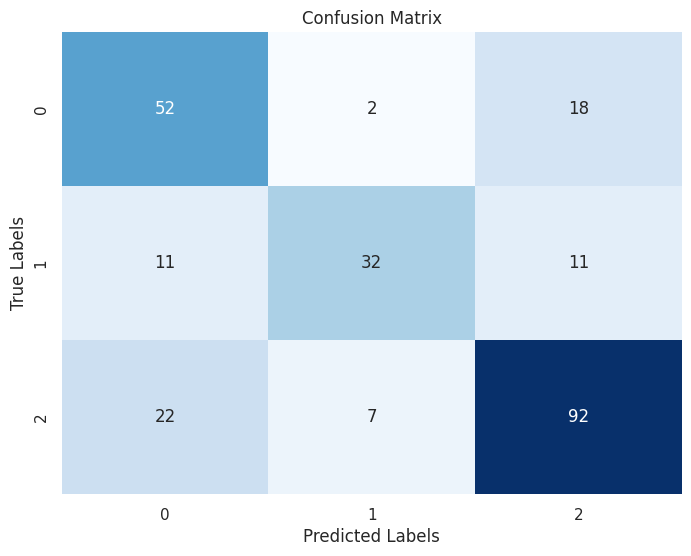

In [38]:
#visualizing my confusion matrix
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [39]:
#Precision, Recall, and F1-Score:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred,average='macro')
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Precision: 0.7175276964242662
Recall: 0.6917151311090706
F1-Score: 0.6988117237347725


In [42]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle



In [43]:
# Assuming you have more than two classes in y_train and y_test
n_classes = len(set(y_train))

# Binarize the output labels
y_train_bin = label_binarize(y_train, classes=list(set(y_train)))
y_test_bin = label_binarize(y_test, classes=list(set(y_test)))

In [44]:
y_probs = model.predict_proba(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

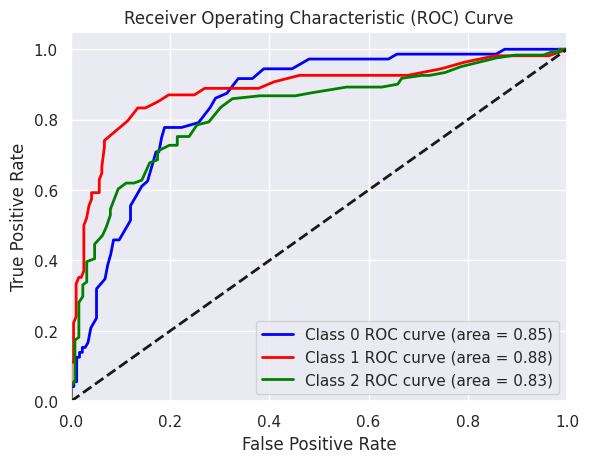

In [45]:
# Plotting the ROC curves for each class
plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} ROC curve (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()